# Capstone: Supervised Learning

## Data
### PBS KIDS Measure Up!

The Dataset contains anonymous gameplay data, including knowledge of videos watched and games played, from the PBS KIDS Measure Up! app.

In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

In [2]:
gameplay_raw = pd.read_csv('train.csv')
assessment_raw = pd.read_csv('train_labels.csv')

In [3]:
gameplay_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11341042 entries, 0 to 11341041
Data columns (total 11 columns):
event_id           object
game_session       object
timestamp          object
event_data         object
installation_id    object
event_count        int64
event_code         int64
game_time          int64
title              object
type               object
world              object
dtypes: int64(3), object(8)
memory usage: 951.8+ MB


In [4]:
assessment_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17690 entries, 0 to 17689
Data columns (total 7 columns):
game_session       17690 non-null object
installation_id    17690 non-null object
title              17690 non-null object
num_correct        17690 non-null int64
num_incorrect      17690 non-null int64
accuracy           17690 non-null float64
accuracy_group     17690 non-null int64
dtypes: float64(1), int64(3), object(3)
memory usage: 967.5+ KB


In [5]:
gameplay_raw.head(5)

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,17eeb7f223665f53,2019-09-06T17:54:17.519Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,77261ab5,0848ef14a8dc6892,2019-09-06T17:54:56.302Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0001e90f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
3,b2dba42b,0848ef14a8dc6892,2019-09-06T17:54:56.387Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,2,3010,53,Sandcastle Builder (Activity),Activity,MAGMAPEAK
4,1bb5fbdb,0848ef14a8dc6892,2019-09-06T17:55:03.253Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,3,3110,6972,Sandcastle Builder (Activity),Activity,MAGMAPEAK


In [6]:
assessment_raw.head(5)

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.0,3


### Columns / Variables
From the data's source we know that installation_id corresponds to an application install on a device, which we'll assume to be a single child.

In [7]:
gameplay_raw.installation_id.nunique()

17000

In [8]:
assessment_IDs = assessment_raw.installation_id.unique()
len(assessment_IDs)

3614

## Installation IDs
We can see that the installation IDs from the gameplay group are not all in correspondence with those from the assessment group.  Meaning that some installation IDs never attempted an assesment.  Because the goal here is to use the gameplay data to forecast how many attempts a child will take to pass a given assessment, we are not interested in the data that does not correspond with an assessment.

In [9]:
#Create a copy of the assessment data in case you need to reload it
assessment_data = assessment_raw.copy()

In [10]:
#Create a new dataframe containing only the relevant instalation IDs for the assessment data
gameplay_data = gameplay_raw.copy()
gameplay_data = gameplay_data[gameplay_data['installation_id'].isin(assessment_IDs)]

In [11]:
len(gameplay_data.installation_id.unique())

3614

In [12]:
gameplay_data

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
1538,27253bdc,34ba1a28d02ba8ba,2019-08-06T04:57:18.904Z,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1539,27253bdc,4b57c9a59474a1b9,2019-08-06T04:57:45.301Z,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
1540,77261ab5,2b9d5af79bcdb79f,2019-08-06T04:58:14.538Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0006a69f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
1541,b2dba42b,2b9d5af79bcdb79f,2019-08-06T04:58:14.615Z,"{""description"":""Let's build a sandcastle! Firs...",0006a69f,2,3010,29,Sandcastle Builder (Activity),Activity,MAGMAPEAK
1542,1325467d,2b9d5af79bcdb79f,2019-08-06T04:58:16.680Z,"{""coordinates"":{""x"":273,""y"":650,""stage_width"":...",0006a69f,3,4070,2137,Sandcastle Builder (Activity),Activity,MAGMAPEAK
...,...,...,...,...,...,...,...,...,...,...,...
11337821,28520915,5448d652309a6324,2019-09-22T02:07:27.562Z,"{""misses"":1,""prompt"":""holds least"",""mode"":""sel...",ffeb0b1b,58,2030,67094,Cauldron Filler (Assessment),Assessment,MAGMAPEAK
11337822,91561152,5448d652309a6324,2019-09-22T02:07:27.562Z,"{""bucket"":1,""buckets_placed"":[3,1,2],""target_b...",ffeb0b1b,57,4025,67094,Cauldron Filler (Assessment),Assessment,MAGMAPEAK
11337823,d3268efa,5448d652309a6324,2019-09-22T02:07:27.566Z,"{""description"":""Awesome."",""identifier"":""Dot_Aw...",ffeb0b1b,59,3021,67094,Cauldron Filler (Assessment),Assessment,MAGMAPEAK
11337824,b5053438,5448d652309a6324,2019-09-22T02:07:28.311Z,"{""description"":""Awesome."",""identifier"":""Dot_Aw...",ffeb0b1b,60,3121,67847,Cauldron Filler (Assessment),Assessment,MAGMAPEAK


Ok, now we have the gameplay data that corresponds to the assessment data. Looking at the features we have to begin with are: event_id - identifier for event type; game_session - identifier for single session of gameplay; timestamp - generated in game timestamp; event_data - structured JSON string containing event data extracted in further features; event_count - counts "events" within game session; event_code - identifier of the event class; game_time - time in milliseconds since the start of the game session; title, type, and world.

In [13]:
gameplay_data.title.value_counts()

Bottle Filler (Activity)         661294
Scrub-A-Dub                      643555
Chow Time                        557864
Sandcastle Builder (Activity)    523052
Fireworks (Activity)             370109
Crystals Rule                    360523
Bug Measurer (Activity)          349862
Bubble Bath                      329548
Pan Balance                      317223
Dino Drink                       311314
Dino Dive                        309230
Chicken Balancer (Activity)      296329
All Star Sorting                 283854
Flower Waterer (Activity)        272504
Air Show                         250257
Happy Camel                      249054
Watering Hole (Activity)         235621
Leaf Leader                      222328
Egg Dropper (Activity)           196725
Mushroom Sorter (Assessment)     192906
Bird Measurer (Assessment)       188466
Chest Sorter (Assessment)        186421
Cauldron Filler (Assessment)     177669
Cart Balancer (Assessment)       158143
Magma Peak - Level 2               8321


In [14]:
assessment_data[assessment_data.title=="Mushroom Sorter (Assessment)"]['accuracy_group'].value_counts()

3    2348
0     594
2     460
1     355
Name: accuracy_group, dtype: int64

In [15]:
assessment_data

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.000000,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.000000,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.000000,3
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.500000,2
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.000000,3
...,...,...,...,...,...,...,...
17685,c996482b11d149dd,ffc90c32,Bird Measurer (Assessment),1,0,1.000000,3
17686,b05a02b52d5c1f4c,ffd2871d,Cauldron Filler (Assessment),1,0,1.000000,3
17687,5448d652309a6324,ffeb0b1b,Cauldron Filler (Assessment),1,2,0.333333,1
17688,a6885ab824fbc32c,ffeb0b1b,Mushroom Sorter (Assessment),0,1,0.000000,0


In [16]:
worlds = gameplay_data.world.unique()
len(worlds)

4

In [17]:
worlds

array(['NONE', 'MAGMAPEAK', 'TREETOPCITY', 'CRYSTALCAVES'], dtype=object)

per user: Number of clips watched, number of activities, total event count

Because of the amount of data we're dealing with here I'm going to look at the information from one world for this project, Magma Peak.

In [18]:
magma_gameplay_data = gameplay_data.loc[gameplay_data.world=='MAGMAPEAK']

In [19]:
magma_gameplay_data

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
1539,27253bdc,4b57c9a59474a1b9,2019-08-06T04:57:45.301Z,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
1540,77261ab5,2b9d5af79bcdb79f,2019-08-06T04:58:14.538Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0006a69f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
1541,b2dba42b,2b9d5af79bcdb79f,2019-08-06T04:58:14.615Z,"{""description"":""Let's build a sandcastle! Firs...",0006a69f,2,3010,29,Sandcastle Builder (Activity),Activity,MAGMAPEAK
1542,1325467d,2b9d5af79bcdb79f,2019-08-06T04:58:16.680Z,"{""coordinates"":{""x"":273,""y"":650,""stage_width"":...",0006a69f,3,4070,2137,Sandcastle Builder (Activity),Activity,MAGMAPEAK
1543,1325467d,2b9d5af79bcdb79f,2019-08-06T04:58:18.474Z,"{""coordinates"":{""x"":863,""y"":237,""stage_width"":...",0006a69f,4,4070,3937,Sandcastle Builder (Activity),Activity,MAGMAPEAK
...,...,...,...,...,...,...,...,...,...,...,...
11337821,28520915,5448d652309a6324,2019-09-22T02:07:27.562Z,"{""misses"":1,""prompt"":""holds least"",""mode"":""sel...",ffeb0b1b,58,2030,67094,Cauldron Filler (Assessment),Assessment,MAGMAPEAK
11337822,91561152,5448d652309a6324,2019-09-22T02:07:27.562Z,"{""bucket"":1,""buckets_placed"":[3,1,2],""target_b...",ffeb0b1b,57,4025,67094,Cauldron Filler (Assessment),Assessment,MAGMAPEAK
11337823,d3268efa,5448d652309a6324,2019-09-22T02:07:27.566Z,"{""description"":""Awesome."",""identifier"":""Dot_Aw...",ffeb0b1b,59,3021,67094,Cauldron Filler (Assessment),Assessment,MAGMAPEAK
11337824,b5053438,5448d652309a6324,2019-09-22T02:07:28.311Z,"{""description"":""Awesome."",""identifier"":""Dot_Aw...",ffeb0b1b,60,3121,67847,Cauldron Filler (Assessment),Assessment,MAGMAPEAK


In [20]:
magma_gameplay_data.title.unique()

array(['Magma Peak - Level 1', 'Sandcastle Builder (Activity)',
       'Slop Problem', 'Scrub-A-Dub', 'Watering Hole (Activity)',
       'Magma Peak - Level 2', 'Dino Drink', 'Bubble Bath',
       'Bottle Filler (Activity)', 'Dino Dive',
       'Cauldron Filler (Assessment)'], dtype=object)

In [21]:
magma_gameplay_data.installation_id.nunique()

3153

In [22]:
assessment_data.installation_id.nunique()

3614

In [23]:
#merged = gameplay_data.merge(assessment_data, how='left', on=['installation_id', 'game_session', 'title'])

merged = magma_gameplay_data.merge(assessment_data, how='left', on=['installation_id'])

In [24]:
merged.shape

(36759532, 17)

In [25]:
magma_gameplay_data.shape

(3208242, 11)

In [26]:
merged.isnull().sum()*100/merged.isnull().count()

event_id           0.0
game_session_x     0.0
timestamp          0.0
event_data         0.0
installation_id    0.0
event_count        0.0
event_code         0.0
game_time          0.0
title_x            0.0
type               0.0
world              0.0
game_session_y     0.0
title_y            0.0
num_correct        0.0
num_incorrect      0.0
accuracy           0.0
accuracy_group     0.0
dtype: float64

In [27]:
assessment_data

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.000000,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.000000,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.000000,3
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.500000,2
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.000000,3
...,...,...,...,...,...,...,...
17685,c996482b11d149dd,ffc90c32,Bird Measurer (Assessment),1,0,1.000000,3
17686,b05a02b52d5c1f4c,ffd2871d,Cauldron Filler (Assessment),1,0,1.000000,3
17687,5448d652309a6324,ffeb0b1b,Cauldron Filler (Assessment),1,2,0.333333,1
17688,a6885ab824fbc32c,ffeb0b1b,Mushroom Sorter (Assessment),0,1,0.000000,0


In [28]:
magma_gameplay_data

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
1539,27253bdc,4b57c9a59474a1b9,2019-08-06T04:57:45.301Z,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
1540,77261ab5,2b9d5af79bcdb79f,2019-08-06T04:58:14.538Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0006a69f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
1541,b2dba42b,2b9d5af79bcdb79f,2019-08-06T04:58:14.615Z,"{""description"":""Let's build a sandcastle! Firs...",0006a69f,2,3010,29,Sandcastle Builder (Activity),Activity,MAGMAPEAK
1542,1325467d,2b9d5af79bcdb79f,2019-08-06T04:58:16.680Z,"{""coordinates"":{""x"":273,""y"":650,""stage_width"":...",0006a69f,3,4070,2137,Sandcastle Builder (Activity),Activity,MAGMAPEAK
1543,1325467d,2b9d5af79bcdb79f,2019-08-06T04:58:18.474Z,"{""coordinates"":{""x"":863,""y"":237,""stage_width"":...",0006a69f,4,4070,3937,Sandcastle Builder (Activity),Activity,MAGMAPEAK
...,...,...,...,...,...,...,...,...,...,...,...
11337821,28520915,5448d652309a6324,2019-09-22T02:07:27.562Z,"{""misses"":1,""prompt"":""holds least"",""mode"":""sel...",ffeb0b1b,58,2030,67094,Cauldron Filler (Assessment),Assessment,MAGMAPEAK
11337822,91561152,5448d652309a6324,2019-09-22T02:07:27.562Z,"{""bucket"":1,""buckets_placed"":[3,1,2],""target_b...",ffeb0b1b,57,4025,67094,Cauldron Filler (Assessment),Assessment,MAGMAPEAK
11337823,d3268efa,5448d652309a6324,2019-09-22T02:07:27.566Z,"{""description"":""Awesome."",""identifier"":""Dot_Aw...",ffeb0b1b,59,3021,67094,Cauldron Filler (Assessment),Assessment,MAGMAPEAK
11337824,b5053438,5448d652309a6324,2019-09-22T02:07:28.311Z,"{""description"":""Awesome."",""identifier"":""Dot_Aw...",ffeb0b1b,60,3121,67847,Cauldron Filler (Assessment),Assessment,MAGMAPEAK


Maybe the merge has to include the world because merging just on installation ID added rows.

In [29]:
assessment_data.title.unique()

array(['Mushroom Sorter (Assessment)', 'Bird Measurer (Assessment)',
       'Cauldron Filler (Assessment)', 'Chest Sorter (Assessment)',
       'Cart Balancer (Assessment)'], dtype=object)

In [30]:
gameplay_data.world.unique()

array(['NONE', 'MAGMAPEAK', 'TREETOPCITY', 'CRYSTALCAVES'], dtype=object)

In [31]:
#df['Price'] = [1500 if x =='Music' else 800 for x in df['Event']] 

assessment_data['world'] = ['MAGMAPEAK' if x=='Cauldron Filler (Assessment)' else 'OTHER' for x in assessment_data.title]

In [32]:
assessment_data

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group,world
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.000000,3,OTHER
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.000000,0,OTHER
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.000000,3,OTHER
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.500000,2,OTHER
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.000000,3,OTHER
...,...,...,...,...,...,...,...,...
17685,c996482b11d149dd,ffc90c32,Bird Measurer (Assessment),1,0,1.000000,3,OTHER
17686,b05a02b52d5c1f4c,ffd2871d,Cauldron Filler (Assessment),1,0,1.000000,3,MAGMAPEAK
17687,5448d652309a6324,ffeb0b1b,Cauldron Filler (Assessment),1,2,0.333333,1,MAGMAPEAK
17688,a6885ab824fbc32c,ffeb0b1b,Mushroom Sorter (Assessment),0,1,0.000000,0,OTHER


In [33]:
merged2 = magma_gameplay_data.merge(assessment_data, how='left', on=['installation_id', 'world'])

In [34]:
merged2.shape

(9938464, 17)

In [35]:
magma_gameplay_data.shape

(3208242, 11)

In [36]:
merged.shape

(36759532, 17)

In [37]:
merged2

,event_id,game_session_x,timestamp,event_data,installation_id,event_count,event_code,game_time,title_x,type,world,game_session_y,title_y,num_correct,num_incorrect,accuracy,accuracy_group
0,27253bdc,4b57c9a59474a1b9,2019-08-06T04:57:45.301Z,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK,NaN,NaN,NaN,NaN,NaN,NaN
1,77261ab5,2b9d5af79bcdb79f,2019-08-06T04:58:14.538Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0006a69f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK,NaN,NaN,NaN,NaN,NaN,NaN
2,b2dba42b,2b9d5af79bcdb79f,2019-08-06T04:58:14.615Z,"{""description"":""Let's build a sandcastle! Firs...",0006a69f,2,3010,29,Sandcastle Builder (Activity),Activity,MAGMAPEAK,NaN,NaN,NaN,NaN,NaN,NaN
3,1325467d,2b9d5af79bcdb79f,2019-08-06T04:58:16.680Z,"{""coordinates"":{""x"":273,""y"":650,""stage_width"":...",0006a69f,3,4070,2137,Sandcastle Builder (Activity),Activity,MAGMAPEAK,NaN,NaN,NaN,NaN,NaN,NaN
4,1325467d,2b9d5af79bcdb79f,2019-08-06T04:58:18.474Z,"{""coordinates"":{""x"":863,""y"":237,""stage_width"":...",0006a69f,4,4070,3937,Sandcastle Builder (Activity),Activity,MAGMAPEAK,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9938459,d3268efa,5448d652309a6324,2019-09-22T02:07:27.566Z,"{""description"":""Awesome."",""identifier"":""Dot_Aw...",ffeb0b1b,59,3021,67094,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,dadd1a4d8ac68ab0,Cauldron Filler (Assessment),1.0,2.0,0.333333,1.0
9938460,b5053438,5448d652309a6324,2019-09-22T02:07:28.311Z,"{""description"":""Awesome."",""identifier"":""Dot_Aw...",ffeb0b1b,60,3121,67847,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,5448d652309a6324,Cauldron Filler (Assessment),1.0,2.0,0.333333,1.0
9938461,b5053438,5448d652309a6324,2019-09-22T02:07:28.311Z,"{""description"":""Awesome."",""identifier"":""Dot_Aw...",ffeb0b1b,60,3121,67847,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,dadd1a4d8ac68ab0,Cauldron Filler (Assessment),1.0,2.0,0.333333,1.0
9938462,2b058fe3,5448d652309a6324,2019-09-22T02:07:31.963Z,"{""session_duration"":71511,""event_count"":61,""ga...",ffeb0b1b,61,2010,71511,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,5448d652309a6324,Cauldron Filler (Assessment),1.0,2.0,0.333333,1.0


In [38]:
merged

,event_id,game_session_x,timestamp,event_data,installation_id,event_count,event_code,game_time,title_x,type,world,game_session_y,title_y,num_correct,num_incorrect,accuracy,accuracy_group
0,27253bdc,4b57c9a59474a1b9,2019-08-06T04:57:45.301Z,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK,6bdf9623adc94d89,Mushroom Sorter (Assessment),1,0,1.000000,3
1,27253bdc,4b57c9a59474a1b9,2019-08-06T04:57:45.301Z,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK,77b8ee947eb84b4e,Bird Measurer (Assessment),0,11,0.000000,0
2,27253bdc,4b57c9a59474a1b9,2019-08-06T04:57:45.301Z,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK,901acc108f55a5a1,Mushroom Sorter (Assessment),1,0,1.000000,3
3,27253bdc,4b57c9a59474a1b9,2019-08-06T04:57:45.301Z,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK,9501794defd84e4d,Mushroom Sorter (Assessment),1,1,0.500000,2
4,27253bdc,4b57c9a59474a1b9,2019-08-06T04:57:45.301Z,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK,a9ef3ecb3d1acc6a,Bird Measurer (Assessment),1,0,1.000000,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36759527,b5053438,5448d652309a6324,2019-09-22T02:07:28.311Z,"{""description"":""Awesome."",""identifier"":""Dot_Aw...",ffeb0b1b,60,3121,67847,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,a6885ab824fbc32c,Mushroom Sorter (Assessment),0,1,0.000000,0
36759528,b5053438,5448d652309a6324,2019-09-22T02:07:28.311Z,"{""description"":""Awesome."",""identifier"":""Dot_Aw...",ffeb0b1b,60,3121,67847,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,dadd1a4d8ac68ab0,Cauldron Filler (Assessment),1,2,0.333333,1
36759529,2b058fe3,5448d652309a6324,2019-09-22T02:07:31.963Z,"{""session_duration"":71511,""event_count"":61,""ga...",ffeb0b1b,61,2010,71511,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,5448d652309a6324,Cauldron Filler (Assessment),1,2,0.333333,1
36759530,2b058fe3,5448d652309a6324,2019-09-22T02:07:31.963Z,"{""session_duration"":71511,""event_count"":61,""ga...",ffeb0b1b,61,2010,71511,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,a6885ab824fbc32c,Mushroom Sorter (Assessment),0,1,0.000000,0


In [39]:
assessment_data

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group,world
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.000000,3,OTHER
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.000000,0,OTHER
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.000000,3,OTHER
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.500000,2,OTHER
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.000000,3,OTHER
...,...,...,...,...,...,...,...,...
17685,c996482b11d149dd,ffc90c32,Bird Measurer (Assessment),1,0,1.000000,3,OTHER
17686,b05a02b52d5c1f4c,ffd2871d,Cauldron Filler (Assessment),1,0,1.000000,3,MAGMAPEAK
17687,5448d652309a6324,ffeb0b1b,Cauldron Filler (Assessment),1,2,0.333333,1,MAGMAPEAK
17688,a6885ab824fbc32c,ffeb0b1b,Mushroom Sorter (Assessment),0,1,0.000000,0,OTHER


In [40]:
merged2.world.unique()

array(['MAGMAPEAK'], dtype=object)

In [41]:
assessment_data.loc[assessment_data.installation_id == 'ffeb0b1b']

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group,world
17687,5448d652309a6324,ffeb0b1b,Cauldron Filler (Assessment),1,2,0.333333,1,MAGMAPEAK
17688,a6885ab824fbc32c,ffeb0b1b,Mushroom Sorter (Assessment),0,1,0.000000,0,OTHER
17689,dadd1a4d8ac68ab0,ffeb0b1b,Cauldron Filler (Assessment),1,2,0.333333,1,MAGMAPEAK


In [42]:
assessment_data.loc[assessment_data.installation_id == '0006a69f']

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group,world
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3,OTHER
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0,OTHER
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3,OTHER
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2,OTHER
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.0,3,OTHER


In [43]:
assessment_data.loc[assessment_data.installation_id == 'ffc90c32']

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group,world
17680,14de9db5ad7dd503,ffc90c32,Cart Balancer (Assessment),1,0,1.000000,3,OTHER
17681,460e8bdc2822b340,ffc90c32,Chest Sorter (Assessment),1,0,1.000000,3,OTHER
17682,7028e68b20c5f586,ffc90c32,Cauldron Filler (Assessment),1,0,1.000000,3,MAGMAPEAK
17683,8f59b0b22325ef96,ffc90c32,Mushroom Sorter (Assessment),1,0,1.000000,3,OTHER
17684,98e91ee8ce88793b,ffc90c32,Mushroom Sorter (Assessment),1,2,0.333333,1,OTHER
17685,c996482b11d149dd,ffc90c32,Bird Measurer (Assessment),1,0,1.000000,3,OTHER


In [44]:
gameplay_data.loc[gameplay_data.game_session == '98e91ee8ce88793b']

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
11329022,3bfd1a65,98e91ee8ce88793b,2019-07-29T21:14:42.934Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",ffc90c32,1,2000,0,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
11329023,db02c830,98e91ee8ce88793b,2019-07-29T21:14:43.111Z,"{""event_count"":2,""game_time"":250,""event_code"":...",ffc90c32,2,2025,250,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
11329024,a1e4395d,98e91ee8ce88793b,2019-07-29T21:14:43.132Z,"{""description"":""Pull three mushrooms out of th...",ffc90c32,3,3010,250,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
11329025,a52b92d5,98e91ee8ce88793b,2019-07-29T21:14:47.084Z,"{""description"":""Pull three mushrooms out of th...",ffc90c32,4,3110,4317,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
11329026,28ed704e,98e91ee8ce88793b,2019-07-29T21:14:47.095Z,"{""height"":2,""coordinates"":{""x"":546,""y"":497,""st...",ffc90c32,5,4025,4317,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
...,...,...,...,...,...,...,...,...,...,...,...
11329079,9d29771f,98e91ee8ce88793b,2019-07-29T21:15:23.094Z,"{""description"":""Alright! This one is the littl...",ffc90c32,58,3021,40293,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
11329080,7da34a02,98e91ee8ce88793b,2019-07-29T21:15:25.687Z,"{""coordinates"":{""x"":192,""y"":583,""stage_width"":...",ffc90c32,59,4070,42900,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
11329081,c74f40cd,98e91ee8ce88793b,2019-07-29T21:15:27.323Z,"{""description"":""Alright! This one is the littl...",ffc90c32,60,3121,44562,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
11329082,6c930e6e,98e91ee8ce88793b,2019-07-29T21:15:27.901Z,"{""duration"":36731,""misses"":2,""event_count"":61,...",ffc90c32,61,2030,45124,Mushroom Sorter (Assessment),Assessment,TREETOPCITY


In [45]:
gameplay_data.loc[gameplay_data.game_session == '77b8ee947eb84b4e']

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
2681,f56e0afc,77b8ee947eb84b4e,2019-08-06T05:35:19.167Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0006a69f,1,2000,0,Bird Measurer (Assessment),Assessment,TREETOPCITY
2682,ec138c1c,77b8ee947eb84b4e,2019-08-06T05:35:19.174Z,"{""stage_number"":1,""event_count"":2,""game_time"":...",0006a69f,2,2020,0,Bird Measurer (Assessment),Assessment,TREETOPCITY
2683,1375ccb7,77b8ee947eb84b4e,2019-08-06T05:35:19.177Z,"{""description"":""Use the caterpillars to measur...",0006a69f,3,3010,0,Bird Measurer (Assessment),Assessment,TREETOPCITY
2684,bdf49a58,77b8ee947eb84b4e,2019-08-06T05:35:23.654Z,"{""description"":""Use the caterpillars to measur...",0006a69f,4,3110,4536,Bird Measurer (Assessment),Assessment,TREETOPCITY
2685,51102b85,77b8ee947eb84b4e,2019-08-06T05:35:24.263Z,"{""hat"":0,""caterpillar"":""left"",""coordinates"":{""...",0006a69f,5,4030,5119,Bird Measurer (Assessment),Assessment,TREETOPCITY
...,...,...,...,...,...,...,...,...,...,...,...
2763,51102b85,77b8ee947eb84b4e,2019-08-06T05:36:47.990Z,"{""hat"":0,""caterpillar"":""right"",""coordinates"":{...",0006a69f,83,4030,88857,Bird Measurer (Assessment),Assessment,TREETOPCITY
2764,4a4c3d21,77b8ee947eb84b4e,2019-08-06T05:36:48.351Z,"{""height"":6,""bird_height"":5,""correct"":false,""c...",0006a69f,84,4025,89224,Bird Measurer (Assessment),Assessment,TREETOPCITY
2765,17113b36,77b8ee947eb84b4e,2019-08-06T05:36:49.155Z,"{""correct"":false,""caterpillars"":[5,8,6],""event...",0006a69f,85,4110,90032,Bird Measurer (Assessment),Assessment,TREETOPCITY
2766,ad2fc29c,77b8ee947eb84b4e,2019-08-06T05:36:49.157Z,"{""description"":""Uh oh. This caterpillar is too...",0006a69f,86,3020,90032,Bird Measurer (Assessment),Assessment,TREETOPCITY


In [46]:
assessment_data = assessment_data.drop(columns=['world'])

In [47]:
merged3 = magma_gameplay_data.merge(assessment_data, how='left', on=['installation_id', 'game_session'])

In [48]:
merged3.shape

(3208242, 16)

In [49]:
magma_gameplay_data.shape

(3208242, 11)

In [50]:
merged3.isnull().sum()*100/merged3.isnull().count()

event_id            0.000000
game_session        0.000000
timestamp           0.000000
event_data          0.000000
installation_id     0.000000
event_count         0.000000
event_code          0.000000
game_time           0.000000
title_x             0.000000
type                0.000000
world               0.000000
title_y            94.612096
num_correct        94.612096
num_incorrect      94.612096
accuracy           94.612096
accuracy_group     94.612096
dtype: float64

In [51]:
merged3

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title_x,type,world,title_y,num_correct,num_incorrect,accuracy,accuracy_group
0,27253bdc,4b57c9a59474a1b9,2019-08-06T04:57:45.301Z,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK,NaN,NaN,NaN,NaN,NaN
1,77261ab5,2b9d5af79bcdb79f,2019-08-06T04:58:14.538Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0006a69f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK,NaN,NaN,NaN,NaN,NaN
2,b2dba42b,2b9d5af79bcdb79f,2019-08-06T04:58:14.615Z,"{""description"":""Let's build a sandcastle! Firs...",0006a69f,2,3010,29,Sandcastle Builder (Activity),Activity,MAGMAPEAK,NaN,NaN,NaN,NaN,NaN
3,1325467d,2b9d5af79bcdb79f,2019-08-06T04:58:16.680Z,"{""coordinates"":{""x"":273,""y"":650,""stage_width"":...",0006a69f,3,4070,2137,Sandcastle Builder (Activity),Activity,MAGMAPEAK,NaN,NaN,NaN,NaN,NaN
4,1325467d,2b9d5af79bcdb79f,2019-08-06T04:58:18.474Z,"{""coordinates"":{""x"":863,""y"":237,""stage_width"":...",0006a69f,4,4070,3937,Sandcastle Builder (Activity),Activity,MAGMAPEAK,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3208237,28520915,5448d652309a6324,2019-09-22T02:07:27.562Z,"{""misses"":1,""prompt"":""holds least"",""mode"":""sel...",ffeb0b1b,58,2030,67094,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,Cauldron Filler (Assessment),1.0,2.0,0.333333,1.0
3208238,91561152,5448d652309a6324,2019-09-22T02:07:27.562Z,"{""bucket"":1,""buckets_placed"":[3,1,2],""target_b...",ffeb0b1b,57,4025,67094,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,Cauldron Filler (Assessment),1.0,2.0,0.333333,1.0
3208239,d3268efa,5448d652309a6324,2019-09-22T02:07:27.566Z,"{""description"":""Awesome."",""identifier"":""Dot_Aw...",ffeb0b1b,59,3021,67094,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,Cauldron Filler (Assessment),1.0,2.0,0.333333,1.0
3208240,b5053438,5448d652309a6324,2019-09-22T02:07:28.311Z,"{""description"":""Awesome."",""identifier"":""Dot_Aw...",ffeb0b1b,60,3121,67847,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,Cauldron Filler (Assessment),1.0,2.0,0.333333,1.0


In [52]:
merged3.columns

Index(['event_id', 'game_session', 'timestamp', 'event_data',
       'installation_id', 'event_count', 'event_code', 'game_time', 'title_x',
       'type', 'world', 'title_y', 'num_correct', 'num_incorrect', 'accuracy',
       'accuracy_group'],
      dtype='object')

In [53]:
merged3.iloc[3208237]

event_id                                                    28520915
game_session                                        5448d652309a6324
timestamp                                   2019-09-22T02:07:27.562Z
event_data         {"misses":1,"prompt":"holds least","mode":"sel...
installation_id                                             ffeb0b1b
event_count                                                       58
event_code                                                      2030
game_time                                                      67094
title_x                                 Cauldron Filler (Assessment)
type                                                      Assessment
world                                                      MAGMAPEAK
title_y                                 Cauldron Filler (Assessment)
num_correct                                                        1
num_incorrect                                                      2
accuracy                          

In [54]:
merged3.iloc[3208237]['event_data']

'{"misses":1,"prompt":"holds least","mode":"selecting","round_number":2,"duration":7067,"event_count":58,"game_time":67094,"event_code":2030}'

In [55]:
merged3.dtypes

event_id            object
game_session        object
timestamp           object
event_data          object
installation_id     object
event_count          int64
event_code           int64
game_time            int64
title_x             object
type                object
world               object
title_y             object
num_correct        float64
num_incorrect      float64
accuracy           float64
accuracy_group     float64
dtype: object

per user: Number of clips watched, number of activities, total event count, game_time

In [56]:
assessmentmerged = merged3.loc[merged3.type=='Assessment']

In [57]:
assessmentmerged

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title_x,type,world,title_y,num_correct,num_incorrect,accuracy,accuracy_group
3225,90d848e0,197a373a77101924,2019-09-14T15:35:41.747Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0006c192,1,2000,0,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,Cauldron Filler (Assessment),1.0,0.0,1.000000,3.0
3226,532a2afb,197a373a77101924,2019-09-14T15:35:42.114Z,"{""buckets"":[3,1,2],""target_bucket"":0,""mode"":""p...",0006c192,3,2020,386,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,Cauldron Filler (Assessment),1.0,0.0,1.000000,3.0
3227,923afab1,197a373a77101924,2019-09-14T15:35:42.114Z,"{""description"":""Put the right sized bucket und...",0006c192,2,3010,386,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,Cauldron Filler (Assessment),1.0,0.0,1.000000,3.0
3228,3ee399c3,197a373a77101924,2019-09-14T15:35:44.808Z,"{""coordinates"":{""x"":761,""y"":529,""stage_width"":...",0006c192,4,4070,3093,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,Cauldron Filler (Assessment),1.0,0.0,1.000000,3.0
3229,37ee8496,197a373a77101924,2019-09-14T15:35:45.335Z,"{""bucket"":2,""buckets"":[3,1,0],""coordinates"":{""...",0006c192,5,4030,3601,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,Cauldron Filler (Assessment),1.0,0.0,1.000000,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3208237,28520915,5448d652309a6324,2019-09-22T02:07:27.562Z,"{""misses"":1,""prompt"":""holds least"",""mode"":""sel...",ffeb0b1b,58,2030,67094,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,Cauldron Filler (Assessment),1.0,2.0,0.333333,1.0
3208238,91561152,5448d652309a6324,2019-09-22T02:07:27.562Z,"{""bucket"":1,""buckets_placed"":[3,1,2],""target_b...",ffeb0b1b,57,4025,67094,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,Cauldron Filler (Assessment),1.0,2.0,0.333333,1.0
3208239,d3268efa,5448d652309a6324,2019-09-22T02:07:27.566Z,"{""description"":""Awesome."",""identifier"":""Dot_Aw...",ffeb0b1b,59,3021,67094,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,Cauldron Filler (Assessment),1.0,2.0,0.333333,1.0
3208240,b5053438,5448d652309a6324,2019-09-22T02:07:28.311Z,"{""description"":""Awesome."",""identifier"":""Dot_Aw...",ffeb0b1b,60,3121,67847,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,Cauldron Filler (Assessment),1.0,2.0,0.333333,1.0


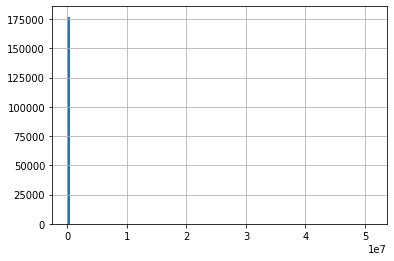

In [58]:
assessmentmerged.game_time.hist(bins=100)

In [59]:
assessmentmerged.game_time.describe()

count    1.776690e+05
mean     6.606709e+04
std      1.241079e+06
min      0.000000e+00
25%      8.925000e+03
50%      1.865200e+04
75%      3.162300e+04
max      5.111195e+07
Name: game_time, dtype: float64

In [60]:
assessmentmerged.game_time.quantile([0, 0.02, 0.05, 0.25, 0.95, 0.97, 0.98])

0.00         0.00
0.02         0.00
0.05       387.00
0.25      8925.00
0.95     72226.80
0.97     93527.00
0.98    122780.36
Name: game_time, dtype: float64

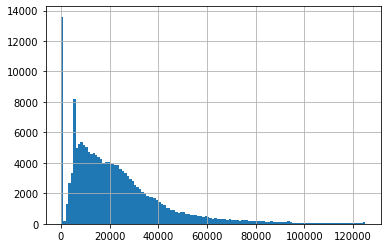

In [61]:
merged3.loc[merged3.type=='Assessment'].game_time.hist(range=(0,125000), bins=125)

In [62]:
merged3

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title_x,type,world,title_y,num_correct,num_incorrect,accuracy,accuracy_group
0,27253bdc,4b57c9a59474a1b9,2019-08-06T04:57:45.301Z,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK,NaN,NaN,NaN,NaN,NaN
1,77261ab5,2b9d5af79bcdb79f,2019-08-06T04:58:14.538Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0006a69f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK,NaN,NaN,NaN,NaN,NaN
2,b2dba42b,2b9d5af79bcdb79f,2019-08-06T04:58:14.615Z,"{""description"":""Let's build a sandcastle! Firs...",0006a69f,2,3010,29,Sandcastle Builder (Activity),Activity,MAGMAPEAK,NaN,NaN,NaN,NaN,NaN
3,1325467d,2b9d5af79bcdb79f,2019-08-06T04:58:16.680Z,"{""coordinates"":{""x"":273,""y"":650,""stage_width"":...",0006a69f,3,4070,2137,Sandcastle Builder (Activity),Activity,MAGMAPEAK,NaN,NaN,NaN,NaN,NaN
4,1325467d,2b9d5af79bcdb79f,2019-08-06T04:58:18.474Z,"{""coordinates"":{""x"":863,""y"":237,""stage_width"":...",0006a69f,4,4070,3937,Sandcastle Builder (Activity),Activity,MAGMAPEAK,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3208237,28520915,5448d652309a6324,2019-09-22T02:07:27.562Z,"{""misses"":1,""prompt"":""holds least"",""mode"":""sel...",ffeb0b1b,58,2030,67094,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,Cauldron Filler (Assessment),1.0,2.0,0.333333,1.0
3208238,91561152,5448d652309a6324,2019-09-22T02:07:27.562Z,"{""bucket"":1,""buckets_placed"":[3,1,2],""target_b...",ffeb0b1b,57,4025,67094,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,Cauldron Filler (Assessment),1.0,2.0,0.333333,1.0
3208239,d3268efa,5448d652309a6324,2019-09-22T02:07:27.566Z,"{""description"":""Awesome."",""identifier"":""Dot_Aw...",ffeb0b1b,59,3021,67094,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,Cauldron Filler (Assessment),1.0,2.0,0.333333,1.0
3208240,b5053438,5448d652309a6324,2019-09-22T02:07:28.311Z,"{""description"":""Awesome."",""identifier"":""Dot_Aw...",ffeb0b1b,60,3121,67847,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,Cauldron Filler (Assessment),1.0,2.0,0.333333,1.0


In [63]:
merged3.timestamp = pd.to_datetime(merged3.timestamp)

In [64]:
merged3.dtypes

event_id                        object
game_session                    object
timestamp          datetime64[ns, UTC]
event_data                      object
installation_id                 object
event_count                      int64
event_code                       int64
game_time                        int64
title_x                         object
type                            object
world                           object
title_y                         object
num_correct                    float64
num_incorrect                  float64
accuracy                       float64
accuracy_group                 float64
dtype: object

In [65]:
merged3 = merged3.sort_values(by=['installation_id', 'timestamp'])

In [66]:
merged3

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title_x,type,world,title_y,num_correct,num_incorrect,accuracy,accuracy_group
0,27253bdc,4b57c9a59474a1b9,2019-08-06 04:57:45.301000+00:00,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK,NaN,NaN,NaN,NaN,NaN
1,77261ab5,2b9d5af79bcdb79f,2019-08-06 04:58:14.538000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0006a69f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK,NaN,NaN,NaN,NaN,NaN
2,b2dba42b,2b9d5af79bcdb79f,2019-08-06 04:58:14.615000+00:00,"{""description"":""Let's build a sandcastle! Firs...",0006a69f,2,3010,29,Sandcastle Builder (Activity),Activity,MAGMAPEAK,NaN,NaN,NaN,NaN,NaN
3,1325467d,2b9d5af79bcdb79f,2019-08-06 04:58:16.680000+00:00,"{""coordinates"":{""x"":273,""y"":650,""stage_width"":...",0006a69f,3,4070,2137,Sandcastle Builder (Activity),Activity,MAGMAPEAK,NaN,NaN,NaN,NaN,NaN
4,1325467d,2b9d5af79bcdb79f,2019-08-06 04:58:18.474000+00:00,"{""coordinates"":{""x"":863,""y"":237,""stage_width"":...",0006a69f,4,4070,3937,Sandcastle Builder (Activity),Activity,MAGMAPEAK,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3208237,28520915,5448d652309a6324,2019-09-22 02:07:27.562000+00:00,"{""misses"":1,""prompt"":""holds least"",""mode"":""sel...",ffeb0b1b,58,2030,67094,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,Cauldron Filler (Assessment),1.0,2.0,0.333333,1.0
3208238,91561152,5448d652309a6324,2019-09-22 02:07:27.562000+00:00,"{""bucket"":1,""buckets_placed"":[3,1,2],""target_b...",ffeb0b1b,57,4025,67094,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,Cauldron Filler (Assessment),1.0,2.0,0.333333,1.0
3208239,d3268efa,5448d652309a6324,2019-09-22 02:07:27.566000+00:00,"{""description"":""Awesome."",""identifier"":""Dot_Aw...",ffeb0b1b,59,3021,67094,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,Cauldron Filler (Assessment),1.0,2.0,0.333333,1.0
3208240,b5053438,5448d652309a6324,2019-09-22 02:07:28.311000+00:00,"{""description"":""Awesome."",""identifier"":""Dot_Aw...",ffeb0b1b,60,3121,67847,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,Cauldron Filler (Assessment),1.0,2.0,0.333333,1.0


In [67]:
merged3 = merged3.drop(columns = ['event_id', 'event_code', 'event_data', 'world', 'title_y', 'num_correct', 'num_incorrect', 'accuracy'])

In [68]:
merged3

,game_session,timestamp,installation_id,event_count,event_code,game_time,title_x,type,accuracy_group
0,4b57c9a59474a1b9,2019-08-06 04:57:45.301000+00:00,0006a69f,1,2000,0,Magma Peak - Level 1,Clip,NaN
1,2b9d5af79bcdb79f,2019-08-06 04:58:14.538000+00:00,0006a69f,1,2000,0,Sandcastle Builder (Activity),Activity,NaN
2,2b9d5af79bcdb79f,2019-08-06 04:58:14.615000+00:00,0006a69f,2,3010,29,Sandcastle Builder (Activity),Activity,NaN
3,2b9d5af79bcdb79f,2019-08-06 04:58:16.680000+00:00,0006a69f,3,4070,2137,Sandcastle Builder (Activity),Activity,NaN
4,2b9d5af79bcdb79f,2019-08-06 04:58:18.474000+00:00,0006a69f,4,4070,3937,Sandcastle Builder (Activity),Activity,NaN
...,...,...,...,...,...,...,...,...,...
3208237,5448d652309a6324,2019-09-22 02:07:27.562000+00:00,ffeb0b1b,58,2030,67094,Cauldron Filler (Assessment),Assessment,1.0
3208238,5448d652309a6324,2019-09-22 02:07:27.562000+00:00,ffeb0b1b,57,4025,67094,Cauldron Filler (Assessment),Assessment,1.0
3208239,5448d652309a6324,2019-09-22 02:07:27.566000+00:00,ffeb0b1b,59,3021,67094,Cauldron Filler (Assessment),Assessment,1.0
3208240,5448d652309a6324,2019-09-22 02:07:28.311000+00:00,ffeb0b1b,60,3121,67847,Cauldron Filler (Assessment),Assessment,1.0
